In [2]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load dataset

In [3]:
df1 = pd.read_csv("./small_2015-06_key_word.csv",index_col=False, header=None, names=['id','text','food','activity','label'])
df2 = pd.read_csv("./small_2015-11_key_word.csv",index_col=False, header=None, names=['id','text','food','activity','label'])
df = pd.concat((df1,df2),axis=0)
lst = []
for i,sentence in enumerate(df['text']):
    try:
        if len(sentence.split(' ')) > 4:
            lst.append(i)
    except:
        continue
df = df.iloc[lst].replace(3,2).reset_index(drop=True)

In [4]:
print(df.shape)
df.head()

(7316139, 5)


,id,text,food,activity,label
0,611162865551192064,for ailment sun remedy none if try find,NaN,NaN,0
1,611165766952591360,remind blessed i walk office today,NaN,walk,2
2,611159320655347712,unarmed white teen shot black officer,NaN,NaN,0
3,611133193811423233,supplemental health care rn register nurse er id,NaN,NaN,0
4,611055426663112705,dad make porn be little frisky,NaN,NaN,0


## Default random forest

Feed different LDA model's output into a __default__ random forest

In [30]:
def feed_lda(num_topics,max_features,max_df,df):
    # load tf_vectorizer and lda model
    tf_path = 'data/tfVectorizer_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    lda_path = 'data/LDA_topics={}_maxFeatures={}_maxDf={}_minDf=1.pickle'.format(num_topics,max_features,max_df)
    name = "topics={}_maxFeatures={}_maxDf={}".format(num_topics,max_features,max_df)
    if (os.path.exists(tf_path)) & ( os.path.exists(lda_path)):
        with open(tf_path,'rb') as input_file:
            tf_vectorizer = pkl.load(input_file)
        with open(lda_path, "rb") as input_file:
            lda = pkl.load(input_file)
            
    # predicts probs of text using lda
    start = time.time()
    probs = lda.transform(tf_vectorizer.transform(df['text'].tolist()))
    X = pd.concat((df,pd.DataFrame(probs)),axis=1)

    # randomly sample a balanced dataset
    X0 = X[X['label']==0].sample(X.groupby('label').size()[2])
    X = pd.concat((X0,X[X['label']==2]),axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,5:],X['label'],test_size=0.2,random_state=42)
    return name, X_train, X_test, y_train, y_test

def do_train(model, X_train, X_test, y_train, y_test):
    # train random forest
    model.fit(X_train,y_train)
    acc = round(model.score(X_test,y_test),4)
    return acc

In [25]:
from sklearn.model_selection import ParameterGrid
grid1 = {'num_topics':[25,50,75,100],
        'max_features':[12000,16000],
        'max_df':[0.4,0.5,0.6]}
grid2 = {'num_topics':[100],
         'max_features':[20000,25000],
         'max_df':[0.5,0.75]}
grid3 = {'num_topics':[125],
         'max_features':[20000,25000],
         'max_df':[0.5]}
comb = list(ParameterGrid(grid1)) + list(ParameterGrid(grid2)) + list(ParameterGrid(grid3))

In [32]:
lda_lst, acc_lst = [], []
for param in comb:
    name, X_train, X_test, y_train, y_test = feed_lda(param['num_topics'], param['max_features'], param['max_df'], df)
    model = RandomForestClassifier(n_estimators=10,random_state=0)
    acc = do_train(model, X_train, X_test, y_train, y_test)
    print(name, acc)
    lda_lst.append(name)
    acc_lst.append(acc)

/Users/ice/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [94]:
default = pd.DataFrame()
default['lda model'] = lda_lst
default['acc'] = acc_lst
default

## Hyperparameter tuning for random forest

### Load our best lda model: num_topics=125, maxFeatures=25000, maxDf=0.5

In [95]:
%%time
_, X_train, X_test, y_train, y_test = feed_lda(125, 25000, 0.5, df)

CPU times: user 10min 57s, sys: 2min 15s, total: 13min 13s
Wall time: 13min 29s


In [98]:
sum(y_train==2), sum(y_train==0)

(312095, 312279)

### ablation study

In [133]:
def tune_param(param, param_lst):
    lst = []
    for val in param_lst:
        locals()[param] = val
        print(param+' =',val)
        start = time.time()
        model = RandomForestClassifier(n_jobs=-1,max_features=max_features,max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_estimators=n_estimators)
        acc = do_train(model, X_train, X_test, y_train, y_test)
        lst.append(acc)
        end = time.time()
        print('acc:',acc)
        print('running time:', round(end-start,4),'s')
    
    df = pd.DataFrame()
    df[param] = param_lst
    df['acc'] = lst
    df = df.sort_values(by=['acc'],ascending=False).reset_index(drop=True)
    return df

In [116]:
# set a default value
bootstrap = False
max_depth = 10
max_features = 50
min_samples_leaf= 2
min_samples_split = 5
n_estimators = 10

In [107]:
# alternative values
grid = {'bootstrap': [True, False],
         'max_depth': [10, 30, 50, 70, 90, None],
         'max_features': ['sqrt', 10, 25, 50, 100],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10, 20],
         'n_estimators': [200, 400, 600, 10]}

- n_estimator

In [114]:
df_n_estimator = tune_param('n_estimator',grid['n_estimator'])
df_n_estimator

,n_estimator,acc
0,100,0.7612
1,10,0.7571
2,200,0.7542
3,600,0.7516
4,400,0.7512


- bootstrap

In [118]:
df_bootstrap = tune_param('bootstrap',grid['bootstrap'])
df_bootstrap

,bootstrap,acc
0,True,0.7634
1,False,0.7612


- max_depth

In [120]:
df_max_depth = tune_param('max_depth',grid['max_depth'])
df_max_depth

,max_depth,acc
0,90.0,0.7620
1,50.0,0.7613
2,NaN,0.7611
3,30.0,0.7600
4,70.0,0.7595
5,10.0,0.7580


- max_features

In [135]:
df_max_features = tune_param('max_features',grid['max_features'])
df_max_features

,max_features,acc
0,100,0.7616
1,150,0.7609
2,25,0.7601
3,50,0.7589


- min_samples_leaf

In [131]:
df_min_samples_leaf = tune_param('min_samples_leaf',grid['min_samples_leaf'])
df_min_samples_leaf

,min_samples_leaf,acc
0,2,0.7625
1,4,0.7591
2,1,0.7561


- min_samples_split

In [130]:
df_min_samples_split = tune_param('min_samples_split',grid['min_samples_split'])
df_min_samples_split

,min_samples_split,acc
0,10.0,0.7646
1,5.0,0.7641
2,2.0,0.7598
3,20.0,0.7595


### best model

In [137]:
%%time
best_model = RandomForestClassifier(n_jobs=-1,max_features=100,max_depth=90,min_samples_leaf=2,min_samples_split=10,n_estimators=100)
best_acc = do_train(best_model, X_train, X_test, y_train, y_test)
print('Best model:', best_model)
print('Best accuracy:', best_acc)

Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best accuracy: 0.8043
CPU times: user 4h 54min 7s, sys: 1min 2s, total: 4h 55min 10s
Wall time: 42min 53s


- feature importance (sum=1)

In [212]:
fi = pd.DataFrame()
fi['importance'] = best_model.feature_importances_
print(fi.sort_values(by=['importance'],ascending=False)[:10])
top4 = list(fi.iloc[:4].index)

     importance
75     0.089479
60     0.062235
104    0.051857
32     0.051118
50     0.031364
106    0.025015
46     0.024168
7      0.024112
122    0.023521
5      0.023253


In [187]:
def print_topics(model, feature_names, top_k, top_topics):
    """
    Print the most important words of each topics
    """
    for ind, topic in enumerate(model.components_):
        if ind in top_topics:
            print("Topic #" + str(ind), 'importance =', round(fi['importance'][ind],4))
            # print out top k possible features(words)
            print([feature_names[i] for i in topic.argsort()[:-top_k-1:-1]])
    return

with open('data/tfVectorizer_topics=125_maxFeatures=25000_maxDf=0.5_minDf=1.pickle','rb') as input_file:
    tf = pkl.load(input_file)
with open('data/LDA_topics=125_maxFeatures=25000_maxDf=0.5_minDf=1.pickle', "rb") as input_file:
    lda = pkl.load(input_file)


feature_names = tf.get_feature_names()
print_topics(lda, feature_names, 30, top4)

Topic #32 importance = 0.0511
['spend', 'believe', 'still', 'warm', 'afternoon', 'read', 'course', 'golf', 'son', 'fashion', 'lie', 'charlie', 'instagram', 'ever', 'zone', 'allow', 'institute', 'indian', 'attend', 'swing', 'chapter', 'recommend', '9th', 'mayor', 'hype', 'costa', 'hollow', 'pan', 'creation', 'highly']
Topic #60 importance = 0.0622
['green', 'sleep', 'bowl', 'continue', 'series', 'blast', 'truck', 'healthy', 'yummy', 'christ', 'ahead', 'pet', 'rally', 'bastard', 'access', 'bored', 'tacos', 'fairfield', 'hawthorne', 'pocket', 'sheet', 'torrance', 'ceiling', 'architecture', 'okc', 'combination', 'fran', 'marinate', 'eating', 'christina']
Topic #75 importance = 0.0895
['run', 'team', 'pizza', 'these', 'chocolate', 'usa', 'attack', 'extra', 'earth', 'salad', 'ground', 'partner', 'david', 'venice', 'pleasure', 'creative', 'edge', 'frank', 'review', 'cancer', 'guard', 'exchange', 'involve', 'powerful', 'resident', 'fund', 'drake', 'sac', 'mag', 'beacon']
Topic #104 importance 

The topic contributes most to our random forest do have some words like 'read','healthy','yummy','pizza','chocolate','run','walk' and etc.

- Load food and activity list

In [230]:
from matplotlib import pyplot as plt

food = list(pkl.load(open("food.pickle","rb")))
food = [i.strip() for i in food]
activity = list(pkl.load(open("activity.pickle","rb")))
activity = [i.strip() for i in activity]

- Plot topics' importance and its food/activity frequency

In [235]:
food_freq_list = []
activity_freq_list = []
combine_freq_list = []

for i in range(len(lda.components_)):
    prob = lda.components_[i] / lda.components_.sum(axis=1)[:, np.newaxis][i]
    # get all the words whose prob > 0.0001 in a specific topic
    top_words_idx = np.where(prob > 0.0001)[0]
    top_words = [tf.get_feature_names()[j] for j in top_words_idx]
    # get frequency of its top words fall into food
    food_freq = sum([word in food for word in top_words])/len(top_words)
    food_freq_list.append(food_freq)
    # get frequency of its top words fall into activity
    activity_freq = sum([word in activity for word in top_words])/len(top_words)
    activity_freq_list.append(activity_freq)
    combine_freq = food_freq + activity_freq
    combine_freq_list.append(combine_freq)

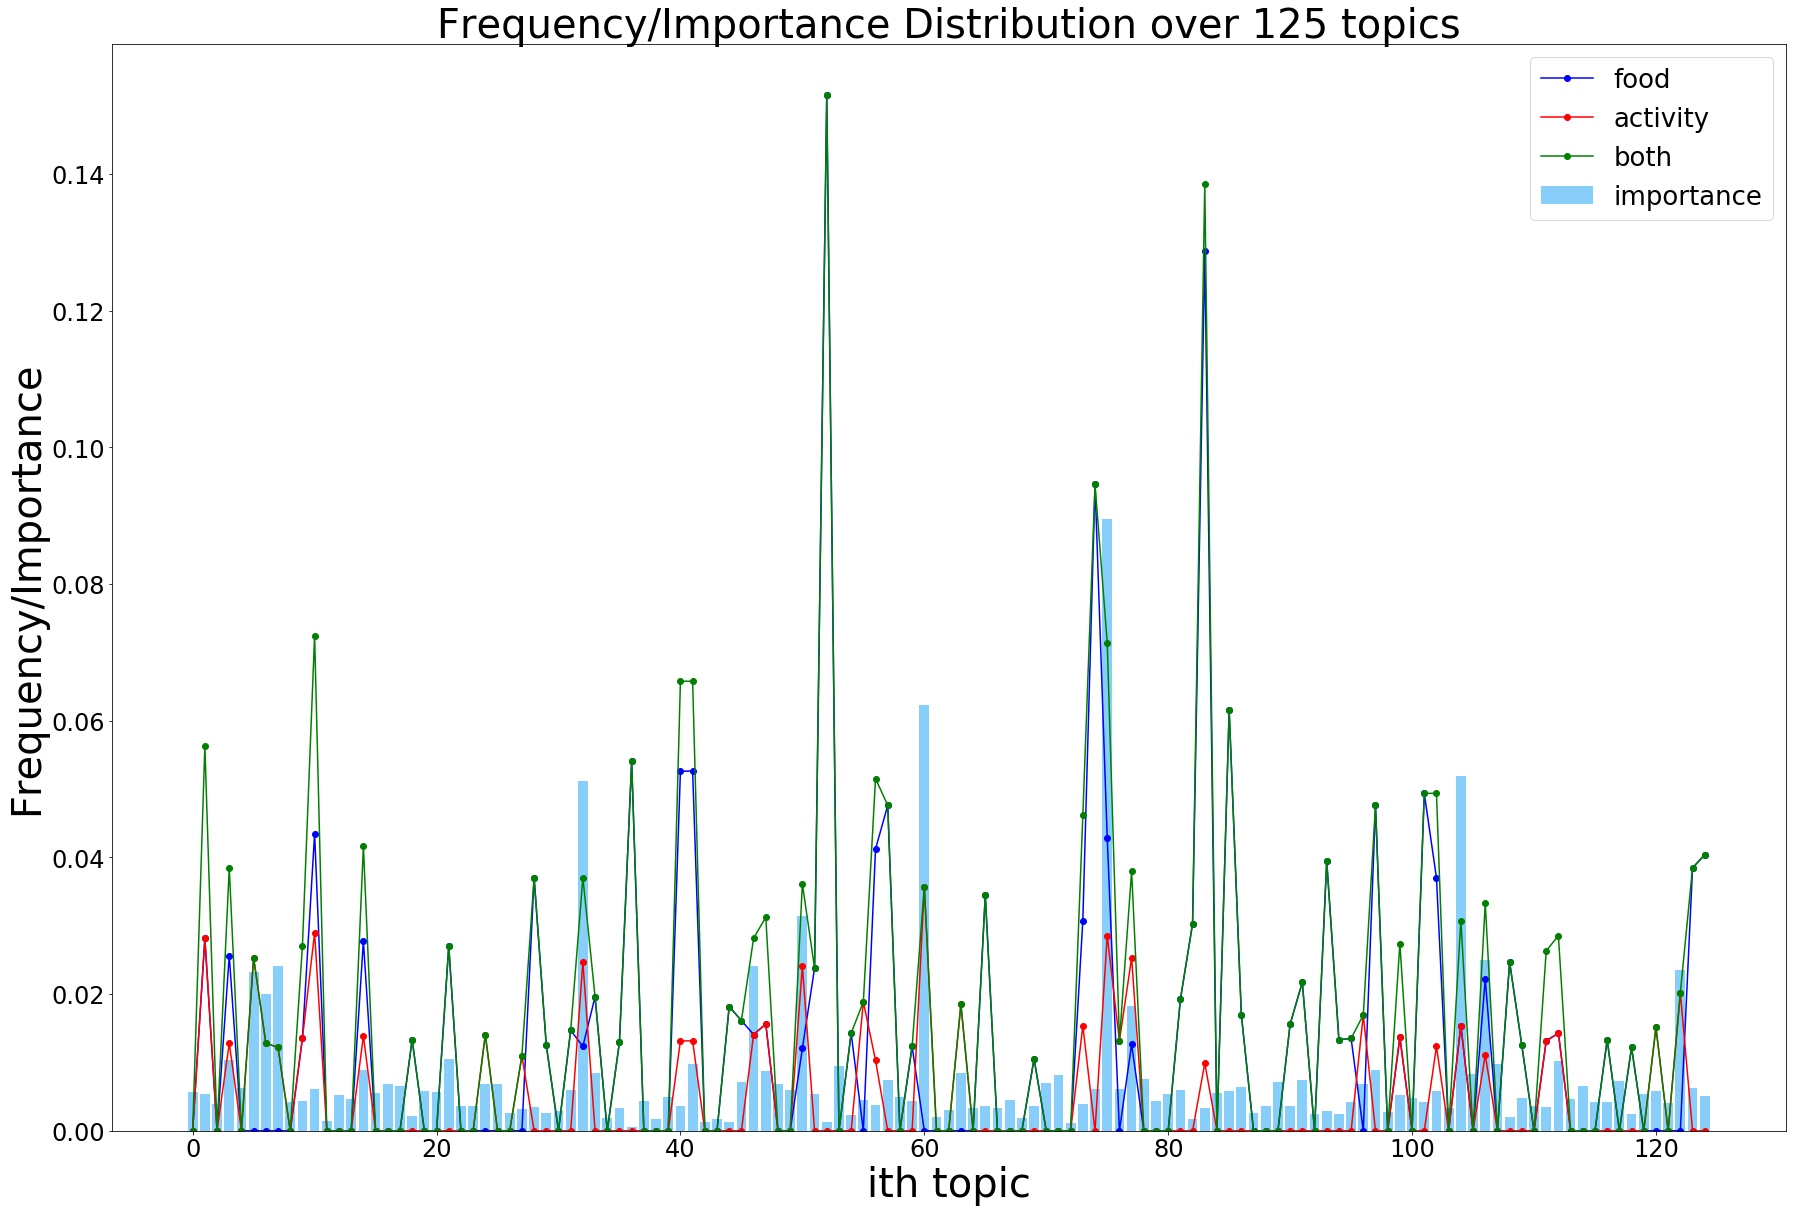

In [234]:
plt.close()
fig = plt.figure(figsize=(30,20))
plt.plot(food_freq_list, label = 'food',color='blue', marker='o')
plt.plot(activity_freq_list,label='activity',color='red',marker = 'o')
plt.plot(combine_freq_list,label = 'both',color='green',marker = 'o' )
plt.bar(range(125),height=fi['importance'],color='lightskyblue',label='importance')
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

plt.title("Frequency/Importance Distribution over 125 topics",fontsize=40)
plt.xlabel("ith topic",fontsize=40)
plt.ylabel('Frequency/Importance',fontsize=40)
plt.legend(prop={'size': 26})

plt.savefig('feature_importance.png') 
plt.show()